In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

print('hello')
# Read data
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')


hello


In [39]:
# Data Preparation

numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score','converted']
categorical = list(set(df.columns)-set(numerical))

df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

df[categorical] = df[categorical].astype('category')

df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [40]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_all_train, test_size=0.25, random_state=1)

df_all_train.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_test.reset_index(inplace=True)

y_all_train = df_all_train['converted'].values
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values


In [41]:
# Question 1: ROC AUC feature importance

# Which numerical variable (among the following 4) has the highest AUC?
# lead_score
# number_of_courses_viewed
# interaction_count
# annual_income

target_columns = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for c in target_columns:
    print('%s: %.3f' % (c, round(roc_auc_score((df_train[c].values>0.5) , y_train),2)))


# Answers: number_of_courses_viewed
#lead_score: 0.590
#number_of_courses_viewed: 0.720
#interaction_count: 0.690
#annual_income: 0.510


lead_score: 0.590
number_of_courses_viewed: 0.720
interaction_count: 0.690
annual_income: 0.510


In [42]:
# Question 2: Training the model

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
converted_decision = (y_pred > 0.5)

print("score: %.3f" % (roc_auc_score(y_val, converted_decision)))


score: 0.738


/tmp/ipykernel_6770/802535582.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))


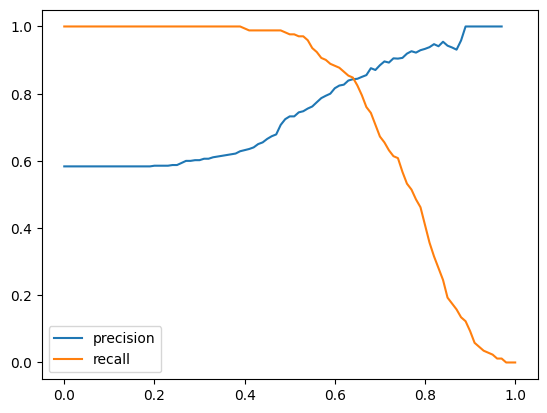

In [ ]:
# Question 3: Precision and Recall

thresholds = np.arange(0,1.01,0.01)

actual_positive = (y_val==1)
actual_negative = (y_val==0)

precisions = []
recalls = []

for th in thresholds:
    predicted_positive = (y_pred >= th)
    predicted_negative = (y_pred < th)

    tp = (actual_positive & predicted_positive).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))

plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.show()

In [ ]:
# Question 4: F1 Score


In [ ]:
# Question 5: 5-Fold CV


In [ ]:
# Question 6: Hyperparameter Tuning